In [7]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(gridExtra)
library(cowplot)
options(repr.matrix.max.rows = 6)

# Predicting the length of tennis games using previous winners' height and age

## Introduction

In the dataset provided by Jeff Sackman, data from tennis matches played by the top 500 players from 2017 to 2019 are provided, with game statistics as well as winner and loser attributes. The data contains 6866 rows of games played in many tournaments from 2017 to 2019. The attributes given include information of the match such as its date, location, type of surface (hard, grass, etc), as well as the length of the match. Information is also given regarding the winners and losers, such as their height, age, dominant hand, and seed **description  and reference needed** Based on these data, we will use multivariable linear regression to predict the length of future tennis matches based on the height and age of winners of previously played tennis matches. Using these data, we will attempt to answer the question: can we predict the length of tennis matches based on the age and height of previous winners? 


In [8]:
tennis_data <- read_csv("https://raw.githubusercontent.com/keelbeier/dsci100-group69/main/atp2017-2019.csv")
tennis_data

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667



Above: our csv file read into R

## Methods

Now, we will wrangle our data into a tidy format. We will remove all columns that we do not need.

In [9]:
tennis_data <- tennis_data |>
                    select(tourney_date, 
                      winner_age, loser_age, winner_ht, minutes) |>
                    mutate(winner_age = round(winner_age)) |>
                    mutate(loser_age = round(loser_age))|>
                    filter(winner_ht != "NA")
tennis_data

tourney_date,winner_age,loser_age,winner_ht,minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20181231,29,23,178,124
20181231,29,32,178,66
20181231,34,20,188,106
⋮,⋮,⋮,⋮,⋮
20171124,33,34,188,106
20171124,27,33,163,164
20171124,24,34,185,94


Warning message:
“Removed 73 rows containing non-finite values (stat_bin).”


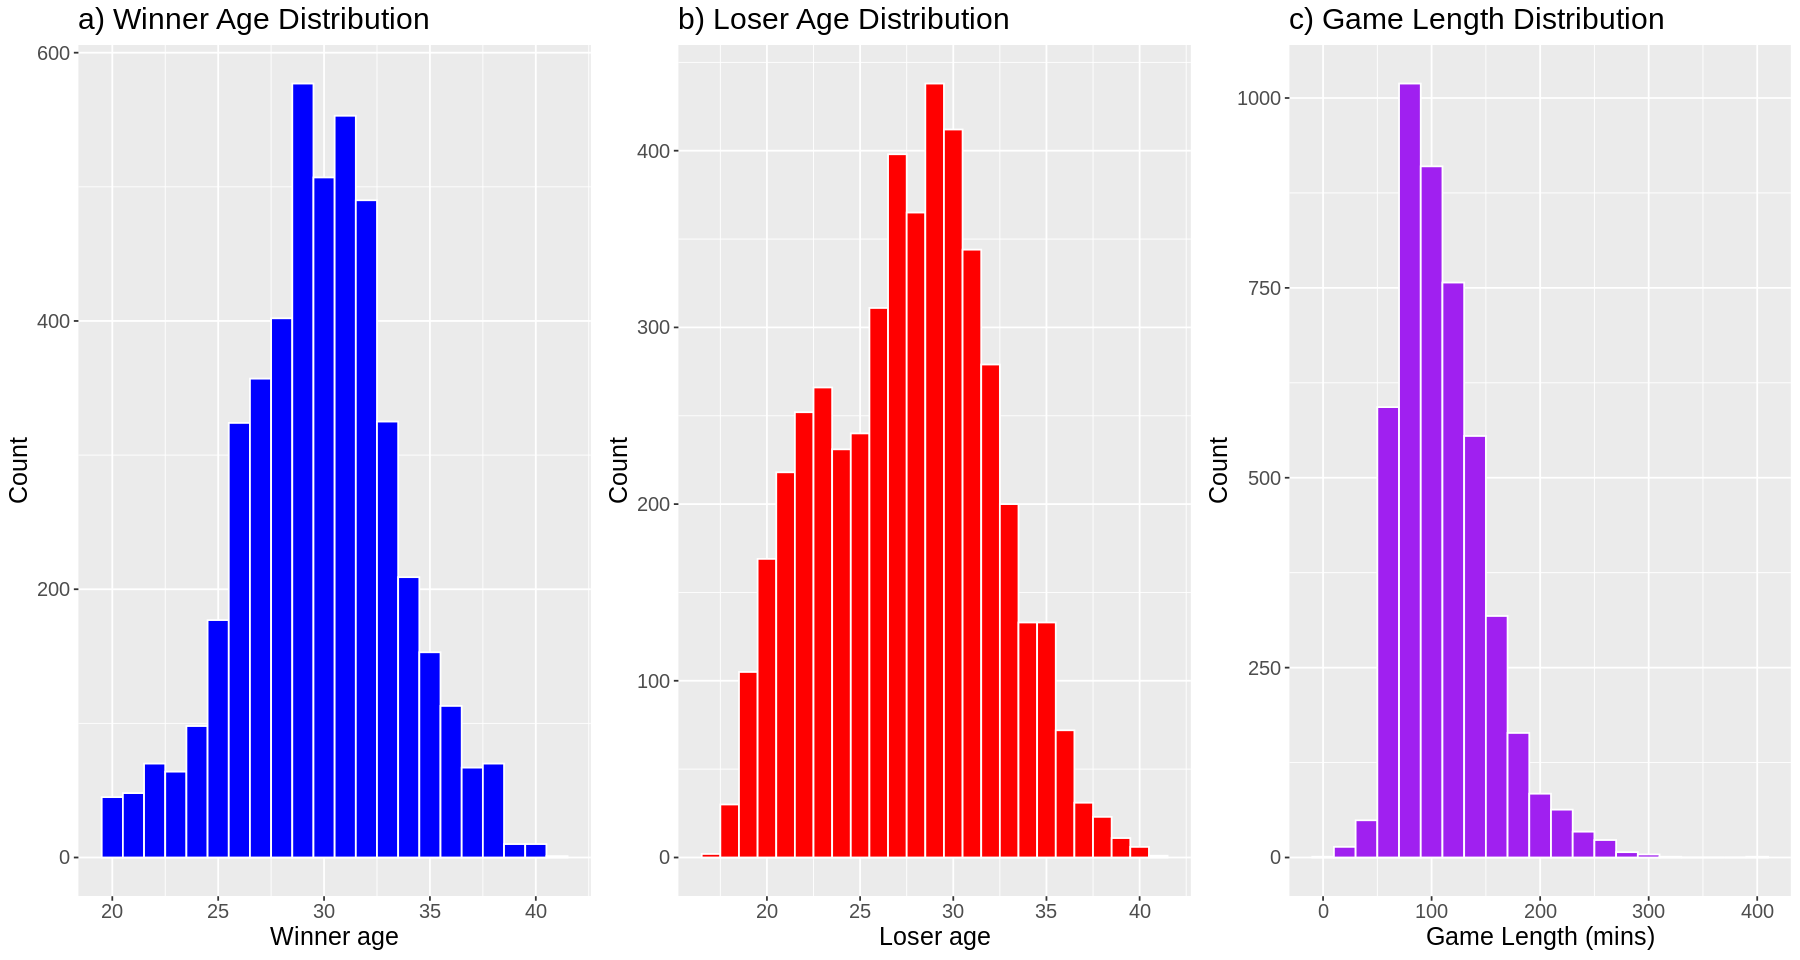

In [10]:
options(repr.plot.width=15, repr.plot.height=8)
winner_age_plot <- tennis_data |> 
    ggplot(aes(x = winner_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "blue") +
    labs(x = "Winner age",
        y = "Count")+
    ggtitle("a) Winner Age Distribution") +
    theme(text = element_text(size = 15))

loser_age_plot <- tennis_data |> 
    ggplot(aes(x = loser_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "red") +
    labs(x = "Loser age",
        y = "Count")+
    ggtitle("b) Loser Age Distribution") +
    theme(text = element_text(size = 15))

time_plot <- tennis_data |> 
    ggplot(aes(x = minutes)) +
    geom_histogram(binwidth = 20, col = "white", fill = "purple") +
    labs(x = "Game Length (mins)",
        y = "Count") +
    ggtitle("c) Game Length Distribution")+
    theme(text = element_text(size = 15))

plot_grid(winner_age_plot, loser_age_plot, time_plot, ncol = 3)

**Figure 1.** a) Winner age distribution. Distribution is normal about the **median** b) Loser age distribution. Distribution shows a slight right skew, indicating that losers are more likely to be below the maximum age of **30??**, c) Distribution of game length in minutes. The distribution shows a right skew, indicating that game length is more likely to fall below the **maximum and median.**

Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


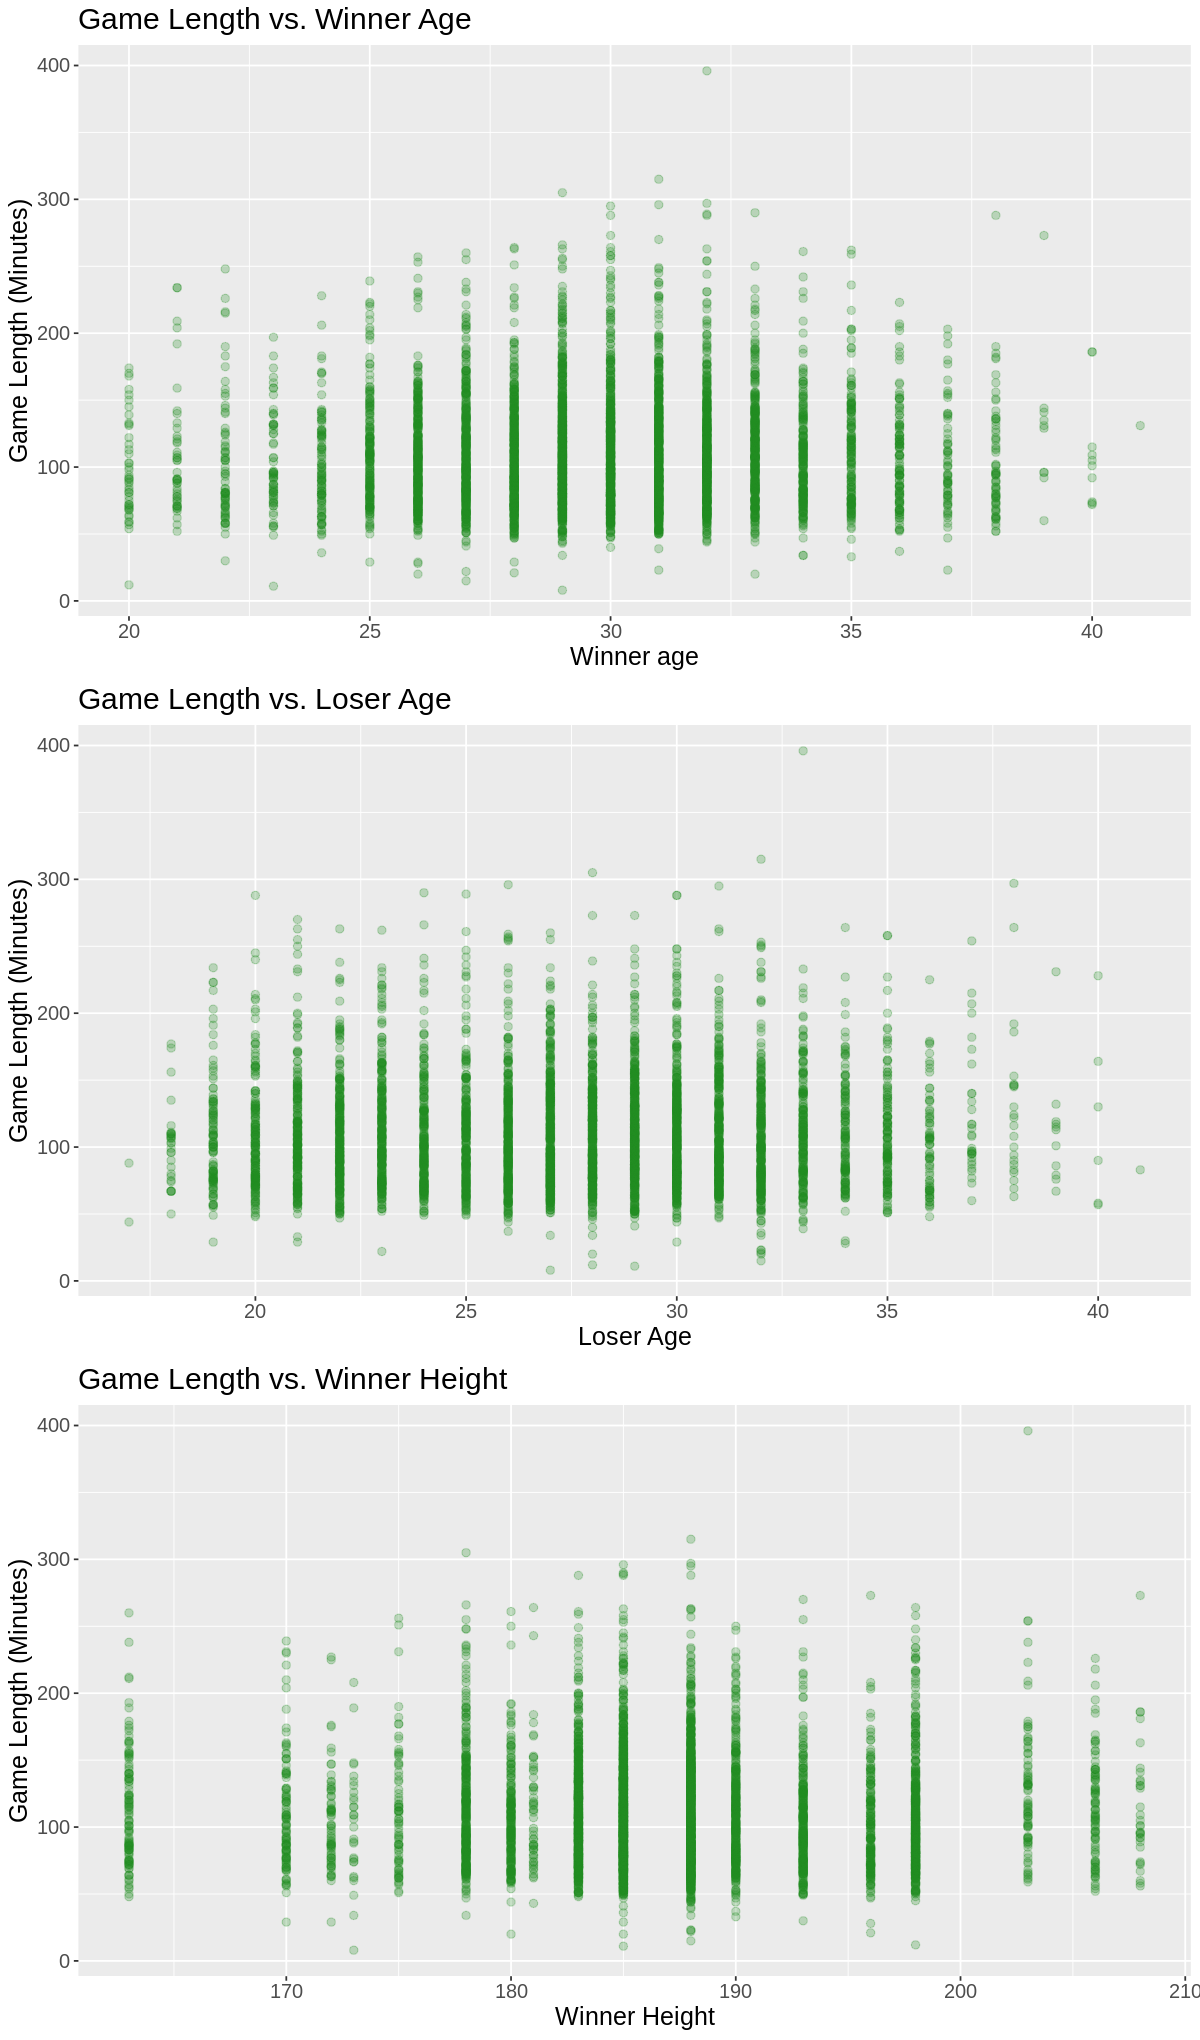

In [13]:
options(repr.plot.width=10, repr.plot.height=17)
winner_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height",) +
    labs(x = "Winner age",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Winner Age") +
    theme(text = element_text(size = 15))

loser_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = loser_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Loser Age",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Loser Age") +
    theme(text = element_text(size = 15))

winner_ht_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Winner Height")  +
    theme(text = element_text(size = 15))

plot_grid(winner_age_scatter_plot, loser_age_scatter_plot, winner_ht_scatter_plot, ncol = 1)

In [14]:
data_split <- initial_split(tennis_data, prop = 0.6, strata = minutes)
data_train <- training(data_split)
data_test <- testing(data_split)

In [15]:
set.seed(2000)

lm_spec <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

lm_recipe <- recipe(minutes ~ winner_ht + winner_age, data = data_train)

lm_fit <- workflow()|>
    add_recipe(lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    winner_ht   winner_age  
   87.00030      0.06457      0.40006  


In [21]:
set.seed(2000)

loser_lm_recipe <- recipe(minutes ~ loser_age, data = data_train)

loser_fit <- workflow()|>
    add_recipe(loser_lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
loser_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    loser_age  
   100.3429       0.3839  


## Results

In [16]:
lm_test_result <- lm_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
lm_test_result
lm_coeffs <- lm_fit |>
    extract_fit_parsnip() |>
    tidy()
lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,41.076688828
rsq,standard,0.000169202
mae,standard,32.014488904


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),87.00029639,18.91721688,4.5990008,0.0000044374
winner_ht,0.06457271,0.09821427,0.6574677,0.5109353120
winner_age,0.40005575,0.22401737,1.7858247,0.0742379173


In [22]:
lm_test_result <- loser_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
lm_test_result
lm_coeffs <- loser_fit |>
    extract_fit_parsnip() |>
    tidy()
lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.114149e+01
rsq,standard,5.126755e-04
mae,standard,3.210496e+01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),100.3429322,4.9847789,20.129866,3.540649e-84
loser_age,0.3838822,0.1781964,2.154265,3.130607e-02


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


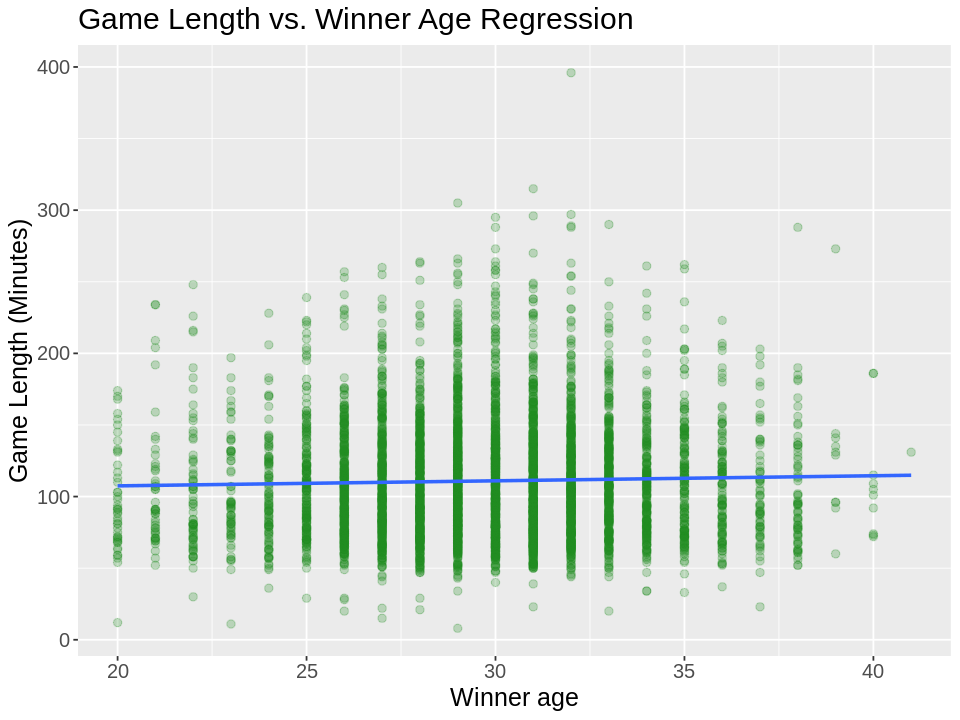

In [23]:
options(repr.plot.width=8, repr.plot.height=6)
regression_age_plot <- winner_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Winner Age Regression")
regression_age_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


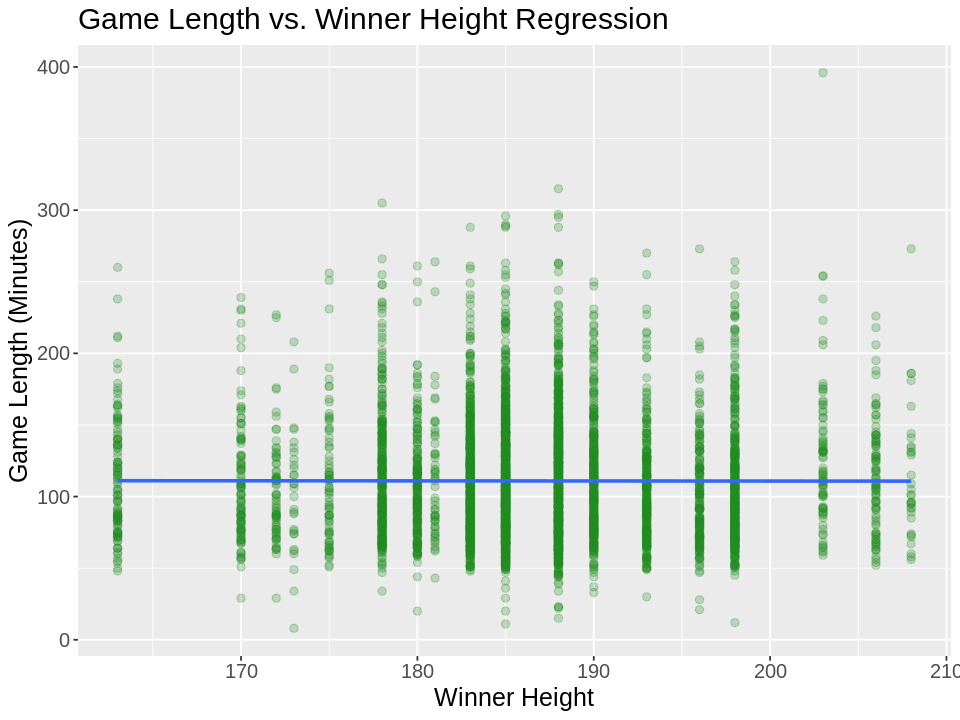

In [24]:
regression_ht_plot <- winner_ht_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Winner Height Regression")
regression_ht_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


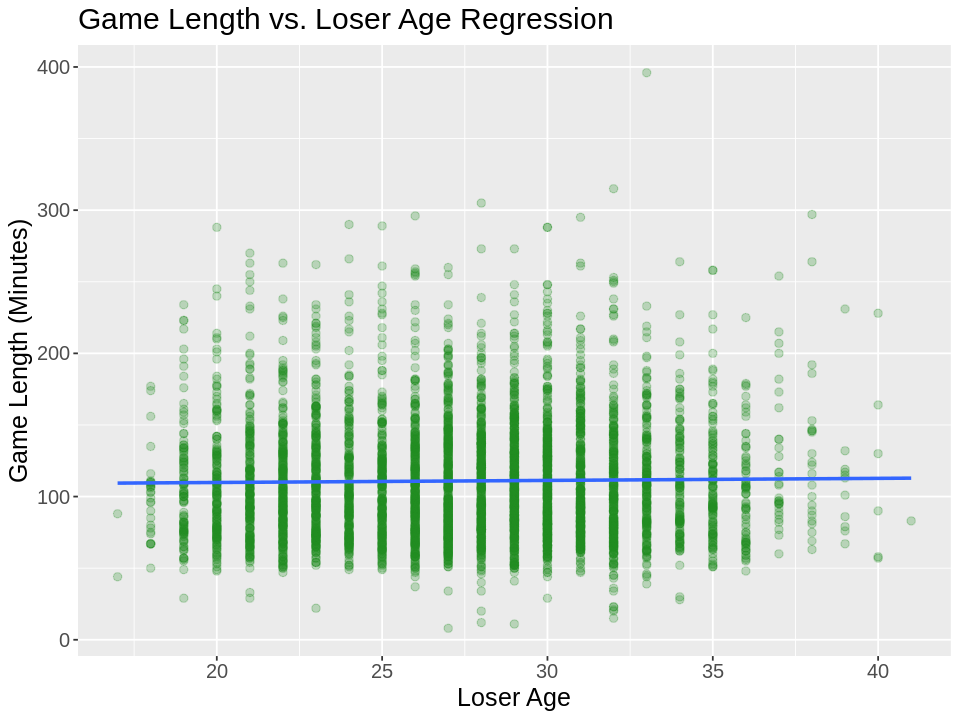

In [26]:
regression_loser_age_plot <- loser_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Loser Age Regression")
regression_loser_age_plot

## Discussion